Create test datasets # Not sure if it's better if we use 27000 or 35000 data# # I commented out some of the anomalies because my old model was strugling with them, we can also try to rerun it with all the anomalies

In [602]:
import random
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
X_train = pd.read_csv('X_train.csv',header=None)
X_train = X_train.to_numpy()
X_train = X_train#[:27000]

def generate_synthetic_anomalies(X_train, num_datasets=5, magnitude=20, introduce_shifts=False, max_shift=200):
    # Define anomaly functions
    anomaly_functions = {
        'segment_inversion': lambda x: x[::-1]*2,
        'flat_spot': lambda x: np.full_like(x, x[0] + random.uniform(10 * magnitude, 20 * magnitude)),
        'random_walk': lambda x: x[0] + np.cumsum(np.random.normal(0, magnitude*5, len(x))),
        'amplitude_modulation': lambda x: x * random.uniform(magnitude / 5, magnitude/3),
        'level_shift': lambda x: x + random.uniform(-40 * magnitude, 40 * magnitude),
        'noise_burst': lambda x: x + np.random.normal(0, 10 * magnitude, len(x)),
        'trend': lambda x: x + np.linspace(0, random.uniform(-50 * magnitude, 50 * magnitude), len(x)),
        'seasonal_change': lambda x: x + np.sin(np.linspace(0, 4 * np.pi, len(x))) * random.uniform(-50 * magnitude, 50 * magnitude)
    }

    # Container for datasets and shifts
    datasets = {}
    shifts = []

    for i in range(1, num_datasets + 1):
        # Create a synthetic test set
        X_test = X_train.values.copy().astype(float) if hasattr(X_train, 'values') else X_train.copy().astype(float)
        Y_test = np.zeros(len(X_test))
        anomaly_types = {}  # Dictionary to store anomaly types

        # Ensure input shapes are 1D
        if len(X_test.shape) > 1:
            X_test = X_test.flatten()

        # Insert anomalies
        inserted_windows = []
        for anomaly_type, anomaly_func in anomaly_functions.items():
            while True:
                anomaly_length = np.random.randint(50, 400)  # Increase anomaly length range
                start = np.random.randint(0, len(X_test) - anomaly_length)
                end = start + anomaly_length

                # Check for overlap
                overlap = any((s <= start < e or s < end <= e) for s, e in inserted_windows)
                if not overlap:
                    inserted_windows.append((start, end))

                    # Apply anomaly
                    X_test[start:end] = anomaly_func(X_test[start:end])

                    Y_test[start:end] = 1
                    anomaly_types[(start, end)] = anomaly_type  # Store the type
                    break

        # Introduce shift if enabled
        if introduce_shifts:
            shift = random.randint(0,max_shift)
            shifts.append(shift)
            if shift > 0:
                X_test = np.roll(X_test, shift)[: len(X_test) - shift]
                Y_test = np.roll(Y_test, shift)[: len(Y_test) - shift]
            else:
                X_test = np.roll(X_test, shift)[-shift:]
                Y_test = np.roll(Y_test, shift)[-shift:]
        else:
            shifts.append(0)  # No shift applied

        # Store results
        datasets[f'X_test_{i}'] = {
            'data': X_test,
            'labels': Y_test,
            'anomaly_types': anomaly_types  # Include anomaly types
        }

        #print(f"Dataset X_test_{i}: {len(inserted_windows)} anomalies inserted. Shift applied: {shifts[-1]}.")

    return datasets, shifts

# Generate synthetic datasets with shifts
# test_datasets, true_shifts = generate_synthetic_anomalies(X_train, introduce_shifts=True, max_shift=200)

# # Print the true shifts for comparison
# print("True shifts applied to datasets:", true_shifts)

# for i in range(1,6):
#     print(len(test_datasets[f'X_test_{i}']['data']))

Visualize anomalies

In [603]:
def visualize_anomalies_single(
    X_train, X_test, labels, anomaly_types, true_shift=None, predicted_scores=None, predicted_shift=None, zoom_before=30, zoom_after=230
):
    """
    Visualize anomalies in the test dataset compared to the training dataset.

    Parameters:
        X_train (np.array): Preprocessed training dataset.
        X_test (np.array): Preprocessed test dataset.
        labels (np.array): Binary array indicating anomalies (1 for anomaly, 0 otherwise).
        anomaly_types (dict): Dictionary of anomaly types with (start, end) as keys.
        shift (int): True shift applied to the dataset.
        predicted_scores (np.array): Predicted anomaly scores for the test dataset.
        predicted_shift (int): Predicted shift applied to align the test dataset.
        zoom_before (int): Number of points to include before the anomaly.
        zoom_after (int): Number of points to include after the anomaly.
    """

    # Find anomaly groups from labels
    anomaly_indices = np.where(labels == 1)[0]

    anomaly_groups = []
    group_start = anomaly_indices[0]

    for i in range(1, len(anomaly_indices)):
        if anomaly_indices[i] != anomaly_indices[i - 1] + 1:
            anomaly_groups.append((group_start, anomaly_indices[i - 1]))
            group_start = anomaly_indices[i]
    anomaly_groups.append((group_start, anomaly_indices[-1]))

    # Create subplots
    num_groups = len(anomaly_groups)
    fig, axes = plt.subplots(num_groups, 1, figsize=(10, 2 * num_groups))
    if num_groups == 1:
        axes = [axes]

    for ax, (start, end) in zip(axes, anomaly_groups):
        zoom_start = max(0, start - zoom_before)
        zoom_end = min(len(X_test), end + zoom_after)

        # Match anomaly type from anomaly_types dictionary
        anomaly_type = "Unknown"
        for (key_start, key_end), anomaly_name in anomaly_types.items():
            if key_start <= start <= key_end or key_start <= end <= key_end:
                anomaly_type = anomaly_name
                break

        # Plot the data
        ax.plot(range(zoom_start, zoom_end), X_test[zoom_start:zoom_end], label="X_test", color='red')
        ax.plot(range(zoom_start, zoom_end), X_train[zoom_start:zoom_end], label="X_train", color='blue', alpha=0.6)
        if predicted_scores is not None:
            ax.plot(
                range(zoom_start, zoom_end),
                predicted_scores[zoom_start:zoom_end],
                label="Predicted Scores",
                color='orange',
                linestyle='--',
            )
        ax.axvline(start, color='green', linestyle='--', label="Anomaly Start")
        ax.axvline(end, color='green', linestyle='--', label="Anomaly End")
        ax.set_title(
            f"Anomaly from {start} to {end} ({anomaly_type}), True Shift: {true_shift}, Predicted Shift: {predicted_shift}"
        )
        ax.set_xlabel("Time")
        ax.set_ylabel("Value")
        ax.legend()
        ax.grid()

    plt.tight_layout()
    plt.show()


Functions to preprocess data 

#TODO test with and without lagged differencing(Better without I think, single test)

#TODO test with differencing first and then deseason later(Better before I think, single test)

#TODO If needed we might need this DTW function to align our timeseries, I failed in implementing it. 

In [604]:
# from sklearn.preprocessing import RobustScaler

# def calculate_seasonal_magnet(data):
#     season_length = 212
#     # Compute the seasonal component (average season) from training data
#     n_windows = len(data) // season_length
#     reshaped_data = data[:n_windows * season_length].reshape((n_windows, season_length))
#     seasonal_magnet = reshaped_data.mean(axis=0)
#     return seasonal_magnet

# def preprocess_train(data, season_length=212):
#     # Ensure data is a 1D array
#     data = data.ravel()
    
#     # Step 1: Calculate seasonal magnet and seasonality
#     seasonal_magnet = calculate_seasonal_magnet(detrended_data)

#     # Step 2: Apply manual differencing for detrending
#     detrended_data = [data[0]]  # Start with the first value (padded with 0 equivalent)
#     for t in range(1, len(data)):
#         detrended_data.append(data[t] - data[t - 1])
#     detrended_data = np.array(detrended_data)

#     # Step 3: Deseason the data
    
#     seasonality = np.tile(seasonal_magnet, (len(detrended_data) // season_length) + 1)[:len(detrended_data)]
#     deseasonalized_data = detrended_data - seasonality

#     # Step 4: Apply RobustScaler
#     scaler = RobustScaler()
#     deseasonalized_data = scaler.fit_transform(deseasonalized_data.reshape(-1, 1)).flatten()
    
#     # Step 6: Apply log transformation
#     deseasonalized_data = np.sign(deseasonalized_data) * np.log1p(np.abs(deseasonalized_data))

#     # Return detrended data, seasonality, and scaler
#     return deseasonalized_data, seasonal_magnet, scaler

# def preprocess_test(data, seasonal_magnet, scaler, season_length=212):
    # Ensure data is a 1D array
    # data = data.ravel()

    # # Step 1: Calculate seasonality
    # seasonality = np.tile(seasonal_magnet, (len(detrended_data) // season_length) + 1)[:len(detrended_data)]

    # # Step 2: Apply manual differencing for detrending
    # detrended_data = [data[0]]  # Start with the first value (padded with 0 equivalent)
    # for t in range(1, len(data)):
    #     detrended_data.append(data[t] - data[t - 1])
    # detrended_data = np.array(detrended_data)

    # # Step 3: Remove seasonality using seasonality from training data
    # deseasonalized_data = detrended_data - seasonality

    # # Step 4: Normalize using the scaler from training data
    # deseasonalized_data = scaler.transform(deseasonalized_data.reshape(-1, 1)).flatten()

    # # Step 5: Apply log transformation
    # deseasonalized_data = np.sign(deseasonalized_data) * np.log1p(np.abs(deseasonalized_data))
    

    # return deseasonalized_data

New preprocess functions that includes shifts

In [605]:
from sklearn.preprocessing import RobustScaler
from scipy.signal import correlate
import numpy as np

# Seasonal Magnet Calculation
def calculate_seasonal_magnet(data, season_length=212):
    """Calculate the average season (seasonal magnet) from training data."""
    n_windows = len(data) // season_length
    reshaped_data = data[:n_windows * season_length].reshape((n_windows, season_length))
    seasonal_magnet = reshaped_data.mean(axis=0)
    return seasonal_magnet

# Best Lag Calculation
def find_best_lag(X_train_seasonality, X_test):
    """Find the lag to align X_test with X_train's seasonal component."""
    correlation = correlate(X_test, X_train_seasonality, mode='full')
    lag = np.argmax(correlation) - (len(X_train_seasonality) - 1)
    return lag

# Preprocessing Training Data
def preprocess_train(data, season_length=212):
    # Ensure data is a 1D array
    data = data.ravel()
    
    # Step 1: Calculate seasonal magnet
    seasonal_magnet = calculate_seasonal_magnet(data, season_length)

    # Step 2: Apply manual differencing for detrending
    detrended_data = [data[0]]  # Start with the first value
    for t in range(1, len(data)):
        detrended_data.append(data[t] - data[t - 1])
    detrended_data = np.array(detrended_data)

    # Step 3: Deseason the data
    seasonality = np.tile(seasonal_magnet, (len(detrended_data) // season_length) + 1)[:len(detrended_data)]
    deseasonalized_data = detrended_data - seasonality

    # Step 4: Normalize using RobustScaler
    scaler = RobustScaler()
    deseasonalized_data = scaler.fit_transform(deseasonalized_data.reshape(-1, 1)).flatten()
    
    # Step 5: Apply log transformation
    deseasonalized_data = np.sign(deseasonalized_data) * np.log1p(np.abs(deseasonalized_data))

    # Return detrended data, seasonal magnet, and scaler
    return deseasonalized_data, seasonal_magnet, scaler, seasonality

def preprocess_test(data, labels, seasonal_magnet, scaler, X_train_seasonality, season_length=212):

    # Ensure data is a 1D array
    data = data.ravel()
    labels = labels.ravel()

    # Step 1: Align test data to training seasonality
    baseline_shift = find_best_lag(X_train_seasonality, data)
    smallest_step_shift = baseline_shift % season_length
        
    aligned_data = np.roll(data, -smallest_step_shift)  # Shift data for alignment
    shifted_labels = np.roll(labels, -smallest_step_shift)  # Shift labels to match alignment
    
    if smallest_step_shift > 0:  # Shifted to the left
        shifted_labels[-smallest_step_shift:] = np.median(data)

    # Step 2: Apply manual differencing for detrending
    detrended_data = [aligned_data[0]]  # Start with the first value
    for t in range(1, len(aligned_data)):
        detrended_data.append(aligned_data[t] - aligned_data[t - 1])
    detrended_data = np.array(detrended_data)

    # Step 3: Remove seasonality using the training seasonal magnet
    seasonality = np.tile(seasonal_magnet, (len(detrended_data) // season_length) + 1)[:len(detrended_data)]
    deseasonalized_data = detrended_data - seasonality

    # Step 4: Normalize using the scaler from training data
    deseasonalized_data = scaler.transform(deseasonalized_data.reshape(-1, 1)).flatten()

    # Step 5: Apply log transformation
    deseasonalized_data = np.sign(deseasonalized_data) * np.log1p(np.abs(deseasonalized_data))
    
    # Return preprocessed data, shifted labels, and the applied shift
    return deseasonalized_data, shifted_labels, smallest_step_shift

In [607]:
# Generate synthetic test datasets with shifts
test_datasets, true_shifts = generate_synthetic_anomalies(X_train, num_datasets=5, introduce_shifts=True, max_shift=200)

# Preprocess training data
X_train_preprocessed, seasonal_magnet, scaler, seasonality = preprocess_train(X_train)

# Create a dictionary to store all preprocessed test datasets
test_datasets_preprocessed = {}
season_length = 212

# Preprocess test datasets and store predicted shifts
for i in range(1, 6):  # Loop through the datasets
    test_data = test_datasets[f'X_test_{i}']['data']
    test_labels = test_datasets[f'X_test_{i}']['labels']
    anomaly_types = test_datasets[f'X_test_{i}']['anomaly_types']
    
    # Preprocess test data
    preprocessed_test, shifted_labels, predicted_shift = preprocess_test(
        test_data, test_labels, seasonal_magnet, scaler, seasonality, season_length=season_length
    )
    
    # Store in dictionary
    test_datasets_preprocessed[f'X_test_{i}'] = {
        'preprocessed_data': preprocessed_test,
        'shifted_labels': shifted_labels,
        'predicted_shift': predicted_shift,
        'true_shift': true_shifts[i - 1],
        'anomaly_types': anomaly_types,
        'test_labels': test_datasets[f'X_test_{i}']['labels']
    }

# Print overall shift accuracy
for i in range(1, 6):
    true_shift = test_datasets_preprocessed[f'X_test_{i}']['true_shift']
    predicted_shift = test_datasets_preprocessed[f'X_test_{i}']['predicted_shift']
    raw_error = abs(true_shift - predicted_shift)
    # circular_error = min(raw_error, season_length - raw_error)
    print(f"  Dataset X_test_{i}: True shift = {true_shift}, Predicted shift = {predicted_shift}", f"Error = {raw_error}")

# # Example: Accessing data from the preprocessed dictionary
# # for i in range(1, 6):
#     preprocessed_data = test_datasets_preprocessed[f'X_test_{i}']['preprocessed_data']
#     shifted_labels = test_datasets_preprocessed[f'X_test_{i}']['shifted_labels']
#     print(f"X_test_{i}: Preprocessed length = {len(preprocessed_data)}, Shifted Labels length = {len(shifted_labels)}")



  Dataset X_test_1: True shift = 0, Predicted shift = 0 Error = 0
  Dataset X_test_2: True shift = 0, Predicted shift = 211 Error = 211
  Dataset X_test_3: True shift = 0, Predicted shift = 1 Error = 1
  Dataset X_test_4: True shift = 0, Predicted shift = 6 Error = 6
  Dataset X_test_5: True shift = 0, Predicted shift = 0 Error = 0


Deviation from the mean or variance on windows Baseline

In [ ]:
# # Define window size and thresholds for mean and variance
# window_size = 40
# variance_threshold = 3 * np.var(X_train)  # Threshold for high variance
# mean_threshold = 3 * std_train  # Threshold for mean deviation

# # Initialize a list to store anomaly labels
# anomaly_labels_window = np.zeros(len(X_test), dtype=bool)

# # Slide a window across the test set
# for i in range(len(X_test) - window_size + 1):
#     window = X_test[i:i + window_size]
#     window_mean = np.mean(window)
#     window_variance = np.var(window)
    
#     # Mark the window as anomalous if conditions are met
#     if abs(window_mean - mean_train) > mean_threshold or window_variance > variance_threshold:
#         anomaly_labels_window[i:i + window_size] = True

# # Plot the results for visualization
# plt.figure(figsize=(12, 6))
# plt.plot(X_test label='Test Data', color='red', alpha=0.7)
# plt.axhline(mean_train + mean_threshold, color='blue', linestyle='--', label='Upper Mean Threshold')
# plt.axhline(mean_train - mean_threshold, color='blue', linestyle='--', label='Lower Mean Threshold')
# plt.scatter(
#     np.where(anomaly_labels_window)[0],
#     X_test[anomaly_labels_window],
#     color='purple',
#     label='Detected Anomalies (Window-Based)',
#     zorder=5,
# )
# plt.axvspan(400, 500, color='yellow', alpha=0.3, label='True Anomaly Region')
# plt.title('Window-Based Anomaly Detection (Mean & Variance) on Synthetic Data')
# plt.xlabel('Time')
# plt.ylabel('Value')
# plt.legend()
# plt.grid()
# plt.show()


ARIMA Baseline

In [ ]:
# from statsmodels.tsa.arima.model import ARIMA

# # Fit ARIMA on the training data
# arima_model = ARIMA(X_train, order=(5, 1, 0))  # Example parameters (p=5, d=1, q=0)
# arima_fit = arima_model.fit()

# # Predict on the test set
# predicted_values = arima_fit.forecast(steps=len(X_test))

# for i in range(1, 6):
#     # Fit ARIMA on the training data
#     arima_model = ARIMA(X_train, order=(5, 1, 0))  # Example parameters (p=5, d=1, q=0)
#     arima_fit = arima_model.fit()

#     # Predict on the test set
#     predicted_values = arima_fit.forecast(steps=len(X_test))

#     # Visualize the results
#     visualize_anomalies_single(
#         X_train_preprocessed,
#         test_datasets_preprocessed[f'X_test_{i}']['preprocessed_data'],
#         test_datasets_preprocessed[f'X_test_{i}']['test_labels'],
#         test_datasets_preprocessed[f'X_test_{i}']['anomaly_types'],
#         true_shift=test_datasets_preprocessed[f'X_test_{i}']['true_shift'],
#         predicted_scores=predicted_values,
#         predicted_shift=test_datasets_preprocessed[f'X_test_{i}']['predicted_shift'],
#     )

# # Plot the results for visualization
# plt.figure(figsize=(12, 6))
# plt.plot(X_test_sample, label='Test Data', color='red', alpha=0.7)
# plt.plot(predicted_values, label='ARIMA Predicted', color='blue', linestyle='--')
# plt.axvspan(400, 500, color='yellow', alpha=0.3, label='True Anomaly Region')
# plt.title('ARIMA Baseline Model on Synthetic Data')
# plt.xlabel('Time')
# plt.ylabel('Value')
# plt.legend()
# plt.grid()
# plt.show()

Exponential Smoothing Baseline

In [ ]:
# from statsmodels.tsa.holtwinters import ExponentialSmoothing

# # Fit Exponential Smoothing on the training data
# ets_model = ExponentialSmoothing(X_train, trend="add", seasonal=None)  # Additive trend, no seasonality
# ets_fit = ets_model.fit()

# # Predict on the test set
# ets_predicted_values = ets_fit.forecast(steps=len(X_test))

# # for i in range(1, 6):
# #     # Fit ARIMA on the training data
# #     ets_model = ARIMA(X_train, order=(5, 1, 0))  # Example parameters (p=5, d=1, q=0)
# #     ets_fit = ets_fit.fit()

# #     # Predict on the test set
# #     predicted_values = ets_fit.forecast(steps=len(X_test))

# #     # Visualize the results
# #     visualize_anomalies_single(
# #         X_train_preprocessed,
# #         test_datasets_preprocessed[f'X_test_{i}']['preprocessed_data'],
# #         test_datasets_preprocessed[f'X_test_{i}']['test_labels'],
# #         test_datasets_preprocessed[f'X_test_{i}']['anomaly_types'],
# #         true_shift=test_datasets_preprocessed[f'X_test_{i}']['true_shift'],
# #         predicted_scores=predicted_values,
# #         predicted_shift=test_datasets_preprocessed[f'X_test_{i}']['predicted_shift'],
# #     )


# # Plot the results for visualization
# plt.figure(figsize=(12, 6))
# plt.plot(X_test_sample, label='Test Data', color='red', alpha=0.7)
# plt.plot(ets_predicted_values, label='ETS Predicted', color='green', linestyle='--')
# plt.axvspan(400, 500, color='yellow', alpha=0.3, label='True Anomaly Region')
# plt.title('Exponential Smoothing Baseline Model on Synthetic Data')
# plt.xlabel('Time')
# plt.ylabel('Value')
# plt.legend()
# plt.grid()
# plt.show()


LSTM Model

In [609]:
# import tensorflow as tf

# def train_lstm_model(X_train, window_size=40, epochs=10, batch_size=64):
#     """
#     Train an LSTM-based autoencoder on the training dataset.

#     Parameters:
#     X_train (np.ndarray): The training dataset.
#     window_size (int): The size of the sliding window for sequences.
#     epochs (int): The number of training epochs.
#     batch_size (int): The batch size for training.

#     Returns:
#     model: The trained LSTM model.
#     scaler: The MinMaxScaler used to normalize the training data.
#     """

#     # Create sequences
#     def create_sequences(data, window_size):
#         sequences = []
#         for i in range(len(data) - window_size):
#             sequences.append(data[i:i + window_size])
#         return np.array(sequences)

#     X_train_sequences = create_sequences(X_train, window_size).reshape(-1, window_size, 1)

#     # Build LSTM Autoencoder
#     model = tf.keras.Sequential([
#         tf.keras.layers.Input(shape=(window_size, 1)),
#         tf.keras.layers.LSTM(64, activation='relu', return_sequences=True),
#         tf.keras.layers.Dropout(0.2),
#         tf.keras.layers.BatchNormalization(),
#         tf.keras.layers.LSTM(32, activation='relu', return_sequences=False),
#         tf.keras.layers.RepeatVector(window_size),
#         tf.keras.layers.LSTM(32, activation='relu', return_sequences=True),
#         tf.keras.layers.Dropout(0.2),
#         tf.keras.layers.BatchNormalization(),
#         tf.keras.layers.LSTM(64, activation='relu', return_sequences=True),
#         tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1))
#     ])

#     model.compile(optimizer='adam', loss='mse')

#     # Train the model
#     model.fit(X_train_sequences, X_train_sequences, epochs=epochs, batch_size=batch_size, shuffle=True, verbose=1)

#     return model

# model = train_lstm_model(X_train_preprocessed, epochs=10)

GRU Model

In [610]:
# import tensorflow as tf

# def train_gru_model(X_train, window_size=40, epochs=10, batch_size=64):
#     """
#     Train a GRU-based autoencoder on the training dataset.

#     Parameters:
#     X_train (np.ndarray): The training dataset.
#     window_size (int): The size of the sliding window for sequences.
#     epochs (int): The number of training epochs.
#     batch_size (int): The batch size for training.

#     Returns:
#     model: The trained GRU model.
#     """

#     # Create sequences
#     def create_sequences(data, window_size):
#         sequences = []
#         for i in range(len(data) - window_size):
#             sequences.append(data[i:i + window_size])
#         return np.array(sequences)

#     X_train_sequences = create_sequences(X_train, window_size).reshape(-1, window_size, 1)

#     # Build GRU Autoencoder
#     model = tf.keras.Sequential([
#         tf.keras.layers.Input(shape=(window_size, 1)),
#         tf.keras.layers.GRU(64, activation='relu', return_sequences=True),
#         tf.keras.layers.Dropout(0.2),
#         tf.keras.layers.BatchNormalization(),
#         tf.keras.layers.GRU(32, activation='relu', return_sequences=False),
#         tf.keras.layers.RepeatVector(window_size),
#         tf.keras.layers.GRU(32, activation='relu', return_sequences=True),
#         tf.keras.layers.Dropout(0.2),
#         tf.keras.layers.BatchNormalization(),
#         tf.keras.layers.GRU(64, activation='relu', return_sequences=True),
#         tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1))
#     ])

#     model.compile(optimizer='adam', loss='mse')

#     # Train the model
#     model.fit(X_train_sequences, X_train_sequences, epochs=epochs, batch_size=batch_size, shuffle=True, verbose=1)

#     return model

# Train the GRU model
#gru_model = train_gru_model(X_train_preprocessed, window_size=40, epochs=20, batch_size=64)

GRU Model but with fancy stuff to make it better

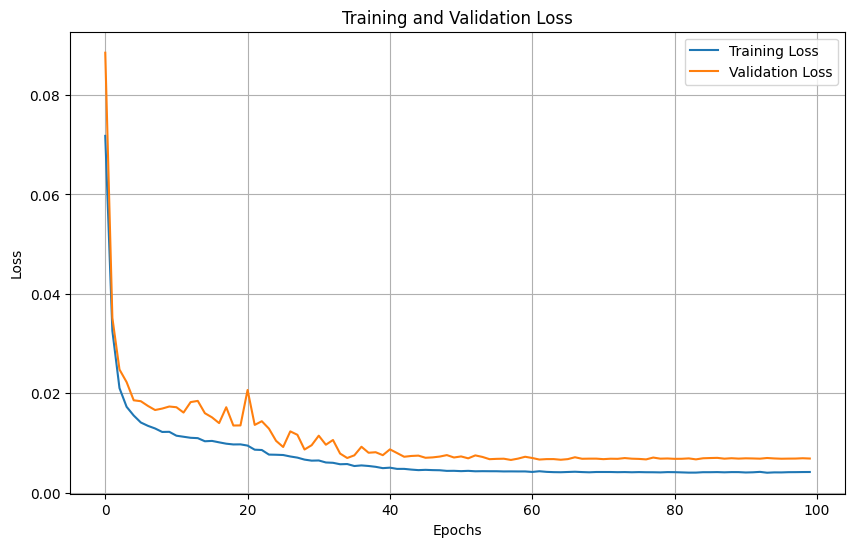

In [611]:
import tensorflow as tf

def train_gru_model(X_train, window_size=40, epochs=100, batch_size=64, patience=4):
    def create_sequences(data, window_size):
        sequences = []
        for i in range(len(data) - window_size):
            sequences.append(data[i:i + window_size])
        return np.array(sequences)

    X_train_sequences = create_sequences(X_train, window_size).reshape(-1, window_size, 1)

    # Split data into training and validation sets
    split_index = int(0.8 * len(X_train_sequences))
    X_val_sequences = X_train_sequences[split_index:]
    X_train_sequences = X_train_sequences[:split_index]

    # Build GRU Autoencoder
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(window_size, 1)),
        tf.keras.layers.GRU(64, activation='relu', return_sequences=True),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.GRU(32, activation='relu', return_sequences=False),
        tf.keras.layers.RepeatVector(window_size),
        tf.keras.layers.GRU(32, activation='relu', return_sequences=True),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.GRU(64, activation='relu', return_sequences=True),
        tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1))
    ])

    model.compile(optimizer='adam', loss='mse')

    # Add callbacks for optimization
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=patience, restore_best_weights=True, verbose=1
    )

    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.8, patience=patience // 2, min_lr=1e-6, verbose=1
    )

    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath='gru_model_checkpoint.keras',  # Use `.keras` extension
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )

    # Train the model
    history = model.fit(
        X_train_sequences,
        X_train_sequences,
        validation_data=(X_val_sequences, X_val_sequences),
        epochs=epochs,
        batch_size=batch_size,
        shuffle=True,
        verbose=1,
        #callbacks=[early_stopping, reduce_lr, checkpoint] # add back early stopping, I think this way we're overfitting
        callbacks=[reduce_lr, checkpoint]
    )

    return model, history

gru_model, history = train_gru_model(X_train_preprocessed, epochs=100)

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

Function to predict anomalies based on the training model

In [612]:
def predict_anomalies(model, X_test, window_size=40):
    # Create sequences
    def create_sequences(data, window_size):
        sequences = []
        for i in range(len(data) - window_size):
            sequences.append(data[i:i + window_size])
        return np.array(sequences)

    X_test_sequences = create_sequences(X_test, window_size).reshape(-1, window_size, 1)

    # Generate reconstruction errors
    X_test_reconstructed = model.predict(X_test_sequences, batch_size=64, verbose=0)
    reconstruction_errors = np.mean(np.abs(X_test_reconstructed - X_test_sequences), axis=(1, 2))

    # Align anomaly scores with the original test set
    anomaly_scores = np.zeros(len(X_test))
    anomaly_scores[window_size:] = reconstruction_errors[:len(X_test) - window_size]

    # Set edges to the median value
    median_value = np.median(anomaly_scores)
    anomaly_scores[:window_size] = median_value
    anomaly_scores[-window_size:] = median_value

    # Normalize anomaly scores
    def log_normalize(scores):
        log_scores = np.log1p(scores)
        max_log_score = np.max(log_scores)
        normalized_scores = log_scores / (max_log_score + 1e-8)
        return normalized_scores

    return log_normalize(anomaly_scores)

# Initialize a dictionary to store predicted scores
predicted_scores = {}

# Predict anomalies and align scores
for i in range(1, 6):
    preprocessed_data = test_datasets_preprocessed[f'X_test_{i}']['preprocessed_data']
    predicted_shift = test_datasets_preprocessed[f'X_test_{i}']['predicted_shift']

    # Predict and align scores
    raw_scores = predict_anomalies(gru_model, preprocessed_data)
    aligned_scores = np.roll(raw_scores, predicted_shift)

    # Mask misaligned regions
    median_value = np.median(raw_scores)
    if predicted_shift > 0:
        aligned_scores[-predicted_shift:] = median_value  # Invalid region
    elif predicted_shift < 0:
        aligned_scores[:abs(predicted_shift)] = median_value  # Invalid region

    # Store results
    predicted_scores[f'X_test_{i}'] = {
        'raw_scores': raw_scores,
        'aligned_scores': aligned_scores
    }


In [614]:
# plt.plot(reconstruction_errors*5, label='Reconstruction error', color='blue', alpha=0.6)
# plt.plot(X_train_preprocessed, label='X_train_preprocessed', color='red', alpha=0.6)
# plt.legend()
# plt.xlim(000, 1000)
# # plt.xlim(1000,2000)
# # plt.xlim(4000,5000)
# # plt.xlim(8500,9500)
# plt.plot()

In [615]:
# predicted_scores_adjusted = {}

# for i in range(1,6):
#     predicted_scores_adjusted[f'X_test_{i}'] = adjust_anomaly_scores(predicted_scores[f'X_test_{i}']['aligned_scores'])


# # Evaluate PATE metrics using stored predictions and synthetic labels
# pate_metrics = []

# for i in range(1, 6):
#     # Retrieve synthetic labels and predicted scores
#     Y_test = test_datasets[f'X_test_{i}']['labels']
#     aligned_scores = predicted_scores_adjusted[f'X_test_{i}']  # Use stored predictions

#     # Evaluate PATE metric
#     pate_metric = PATE(Y_test, aligned_scores)
#     pate_metrics.append(pate_metric)

# # Print PATE metrics for each dataset
# print("PATE scores:", pate_metrics)

# # Calculate and print the mean PATE metric
# print("PATE mean score:", np.mean(pate_metrics))

Evaluation before score adjustments

In [616]:
from pate.PATE_metric import PATE

# Evaluate PATE metrics using stored predictions and synthetic labels
pate_metrics = []

for i in range(1, 6):
    # Retrieve synthetic labels and predicted scores
    Y_test = test_datasets[f'X_test_{i}']['labels']
    aligned_scores = predicted_scores[f'X_test_{i}']['aligned_scores']  # Use stored predictions

    # Evaluate PATE metric
    pate_metric = PATE(Y_test, aligned_scores)
    pate_metrics.append(pate_metric)

# Print PATE metrics for each dataset
print("PATE scores:", pate_metrics)

# Calculate and print the mean PATE metric
print("PATE mean score:", np.mean(pate_metrics))

Visualizing results before score adjustments

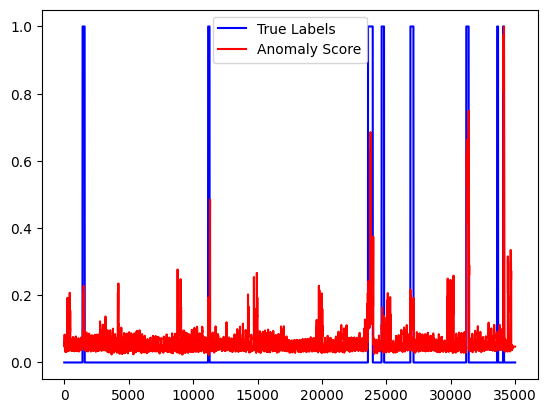

In [617]:
for i in range(1, 6):
    plt.figure(figsize=(14, 6))
    plt.plot(test_datasets[f'X_test_{i}']['labels'], label=f"X_test_{i}")
    plt.plot(predicted_scores[f'X_test_{i}']['aligned_scores'], label="Anomaly Score", color='red')
    plt.legend()
    plt.title(f"Anomaly Scores for X_test_{i}")
    plt.show()
    
plt.plot(test_datasets['X_test_2']['labels'], label='True Labels', color='blue')
plt.plot(predicted_scores['X_test_2']['aligned_scores'], label='Anomaly Score', color='red')
plt.legend()
#lt.xlim(0,100)
plt.show()

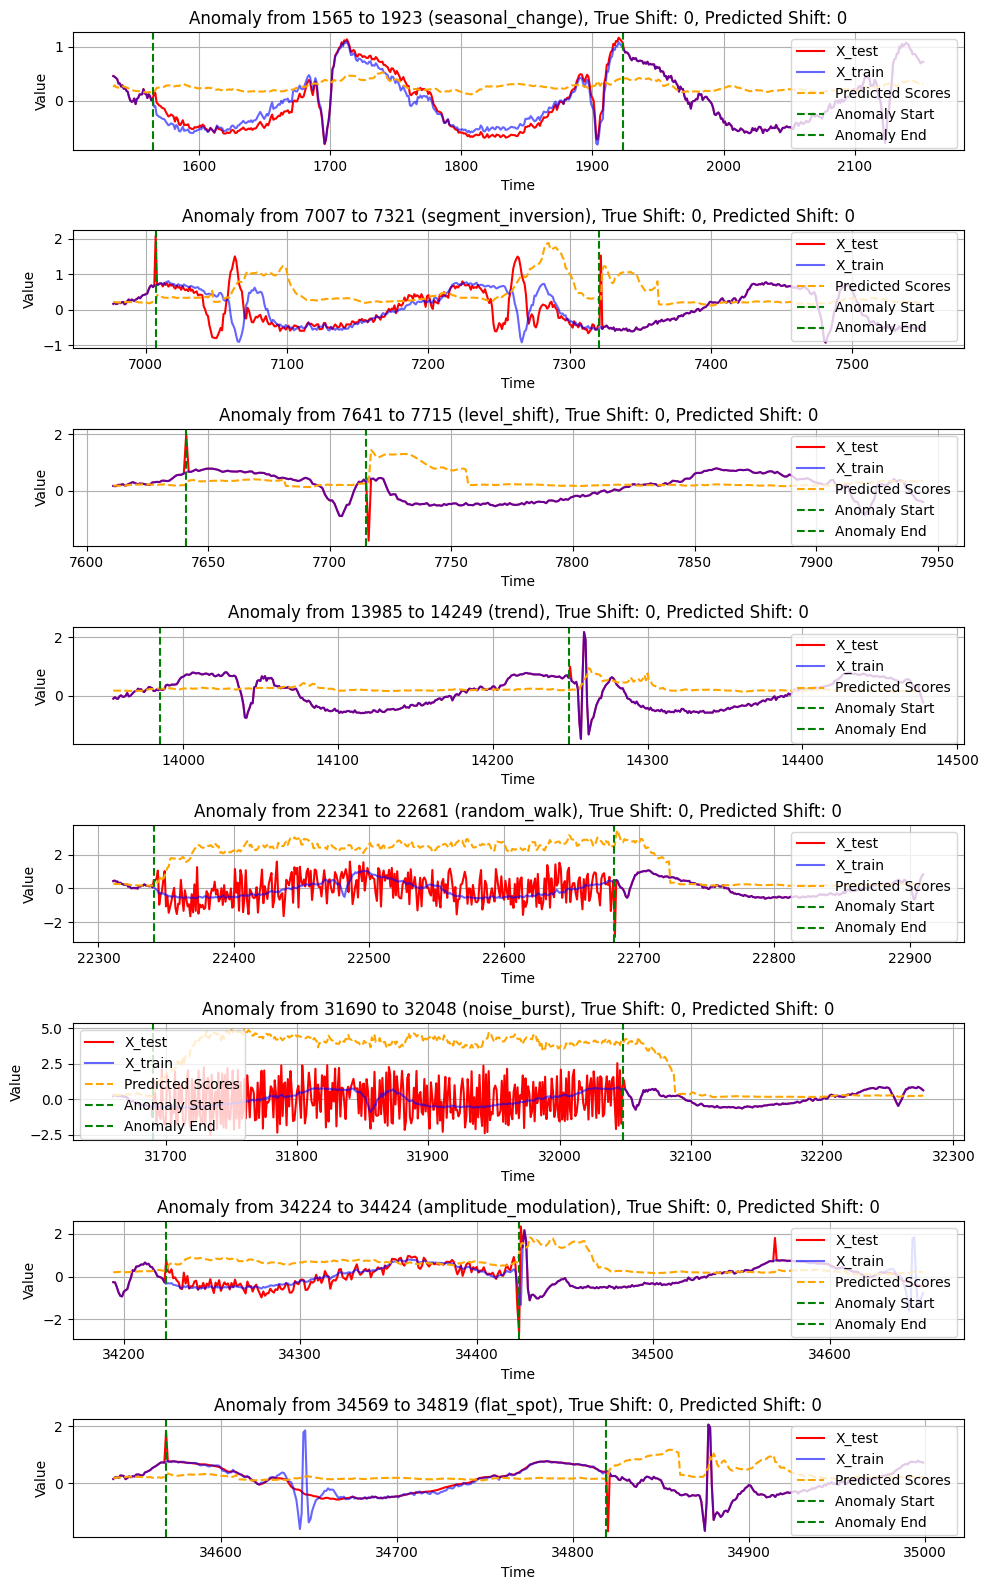

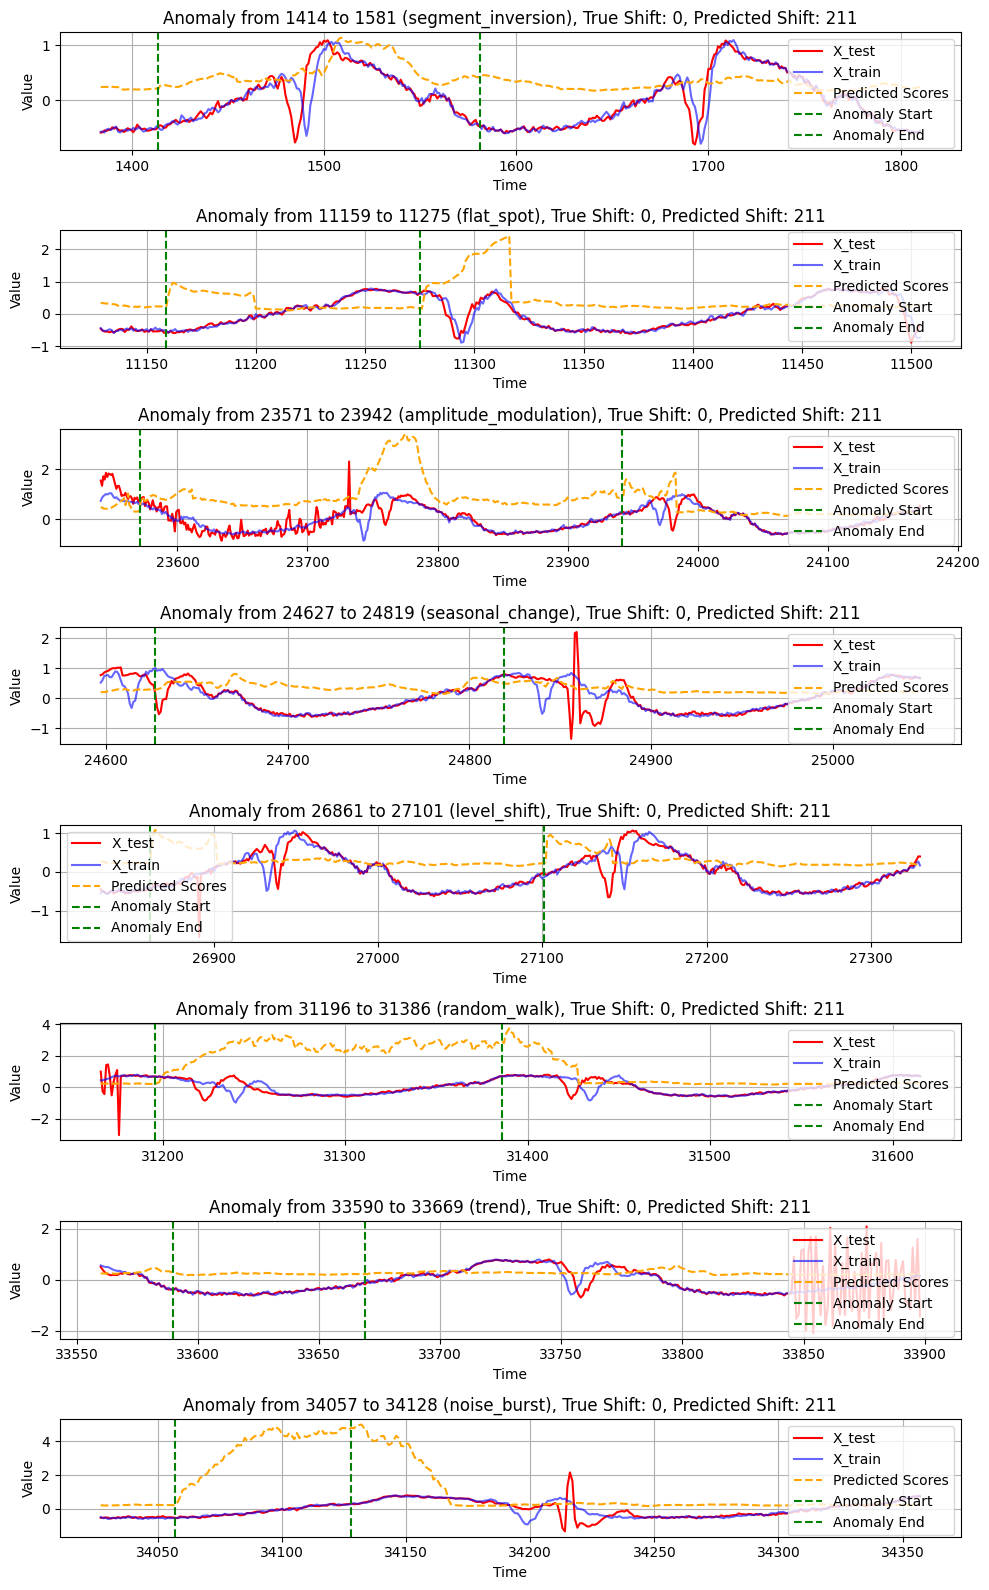

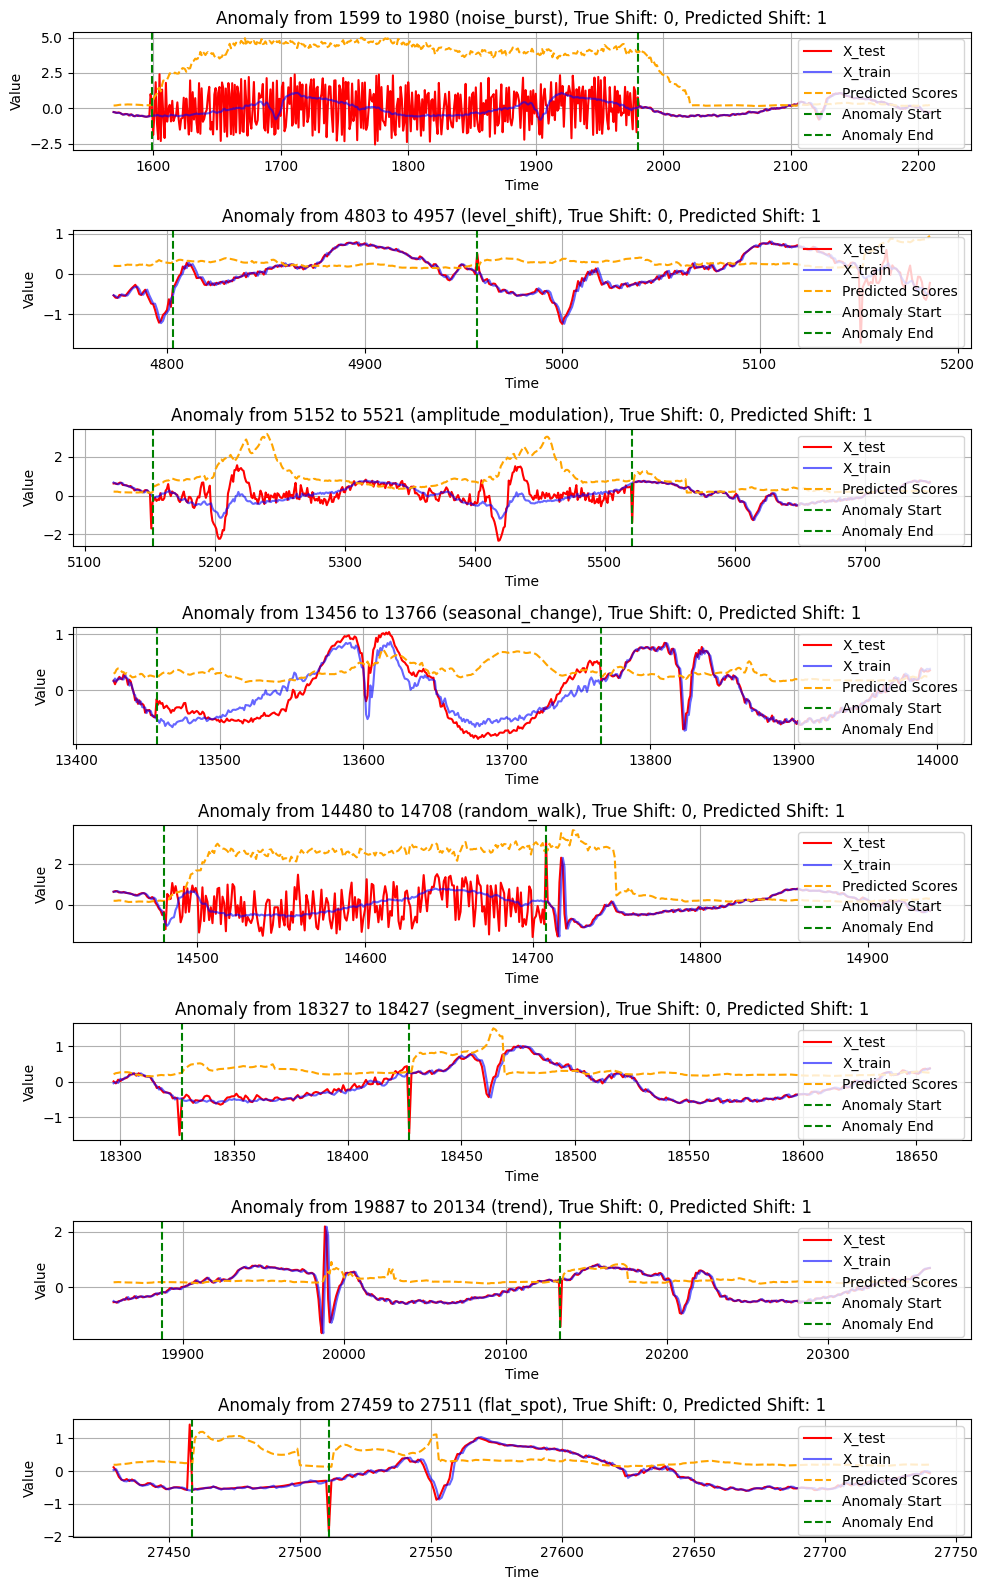

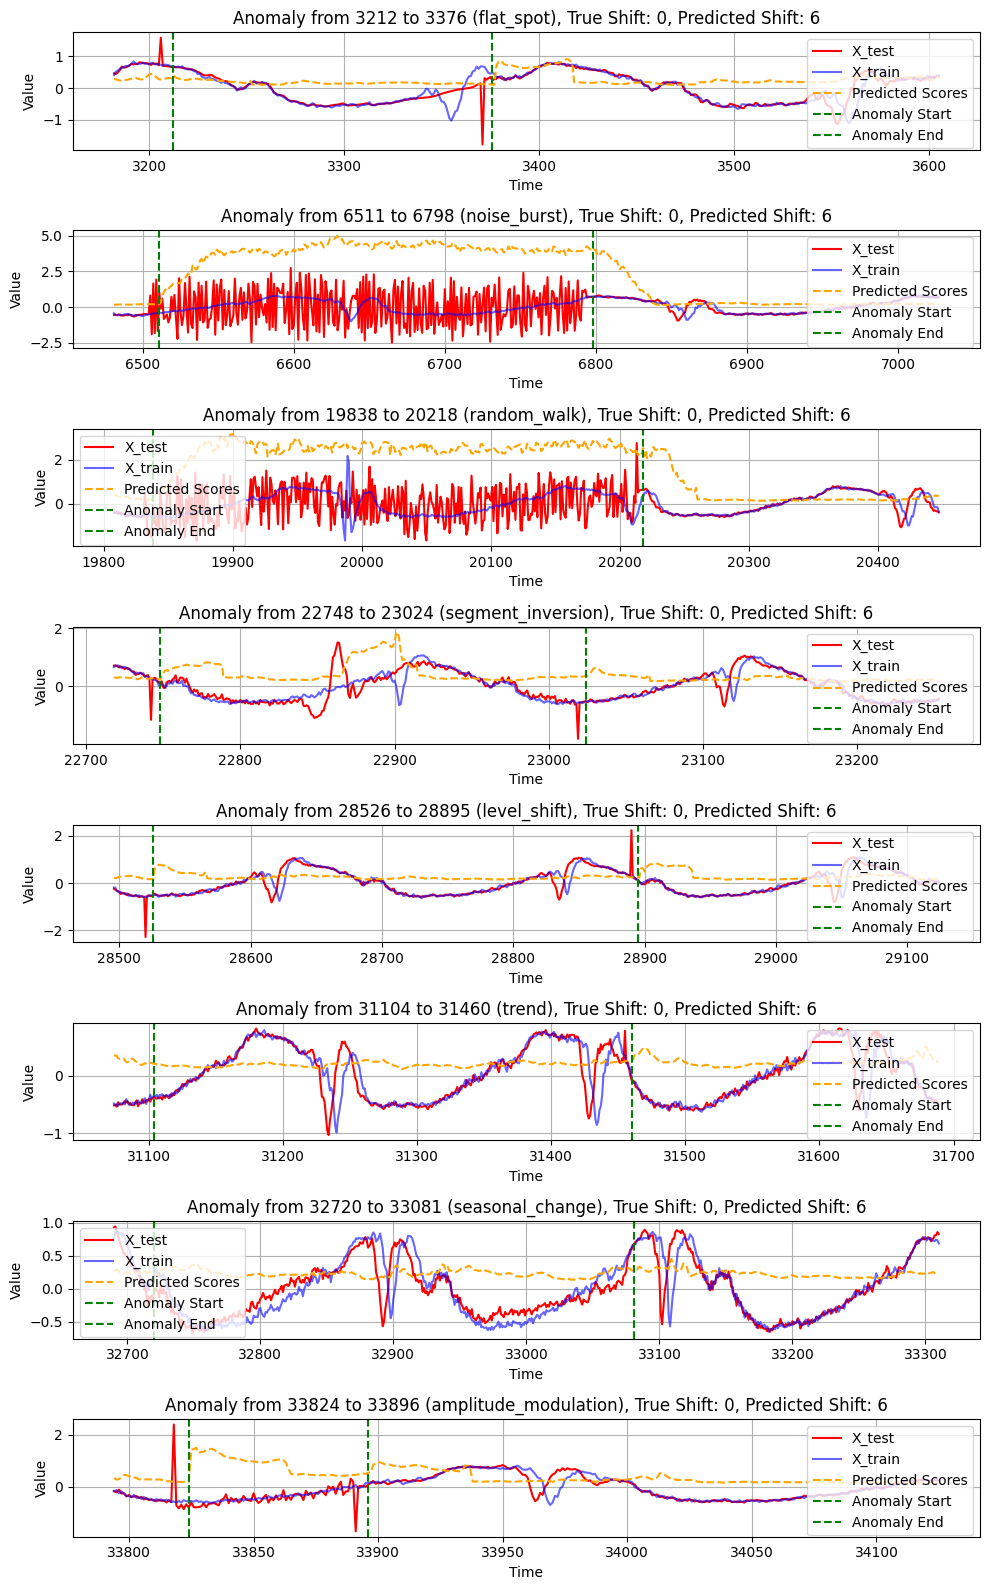

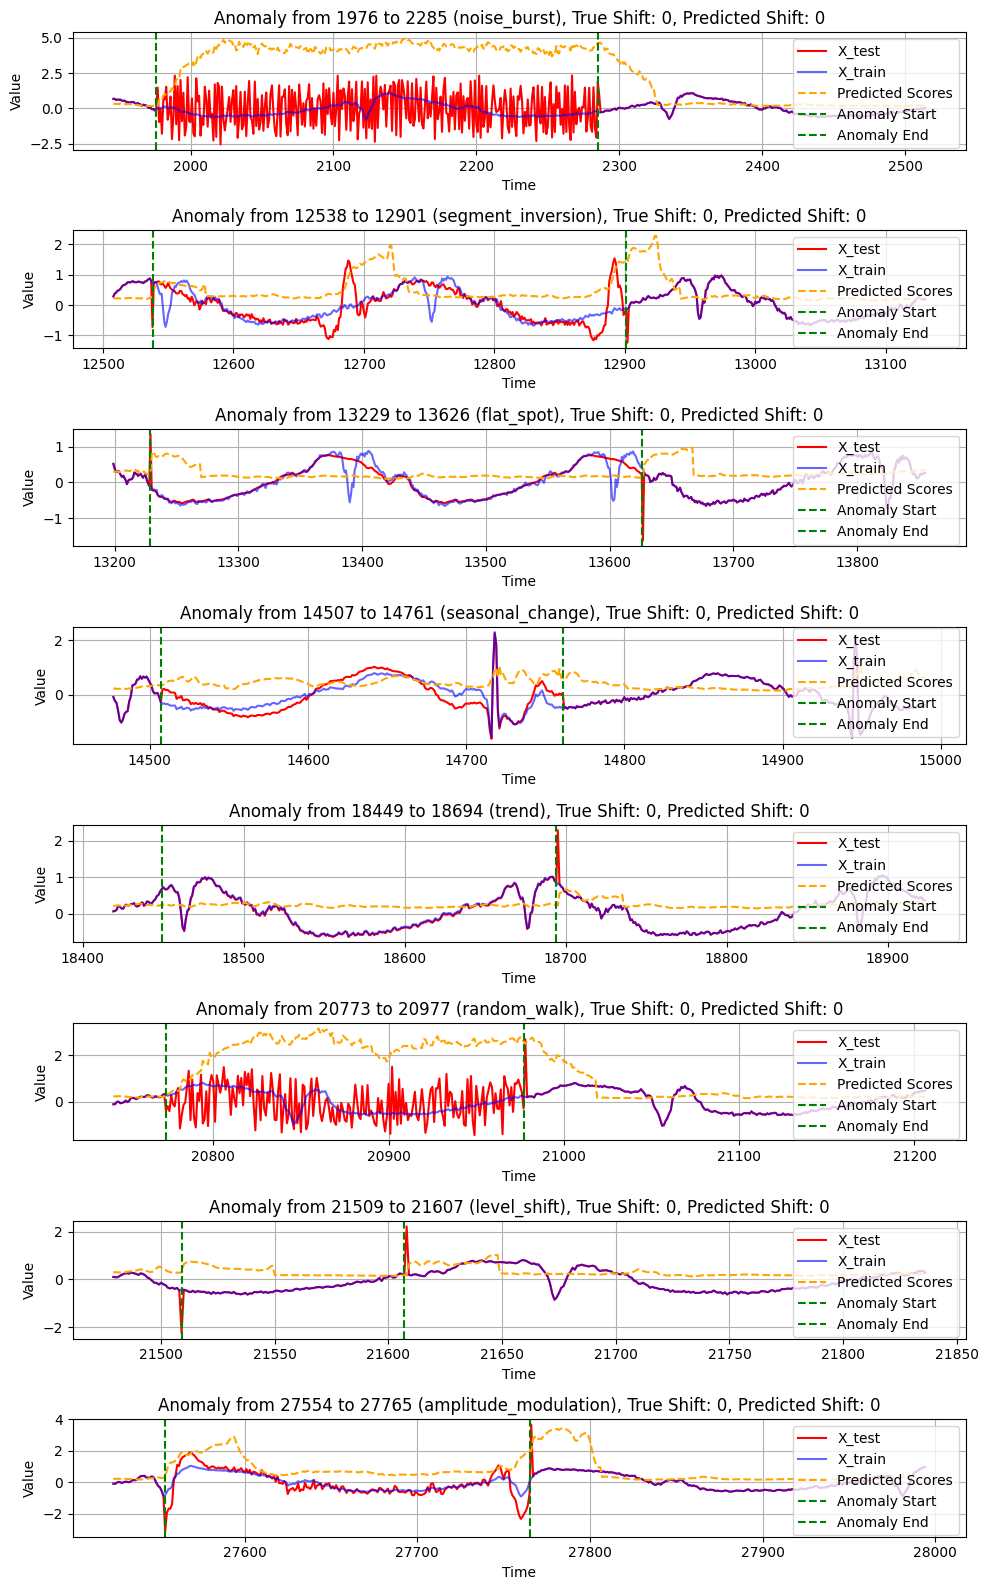

In [618]:
for i in range(1, 6):
    # Visualize anomalies
    visualize_anomalies_single(
        X_train=X_train_preprocessed,
        X_test=test_datasets_preprocessed[f'X_test_{i}']['preprocessed_data'],
        labels=test_datasets[f'X_test_{i}']['labels'],
        anomaly_types=test_datasets[f'X_test_{i}']['anomaly_types'],
        true_shift=test_datasets_preprocessed[f'X_test_{i}']['true_shift'],
        predicted_scores=predicted_scores[f'X_test_{i}']['aligned_scores']*5,
        predicted_shift=test_datasets_preprocessed[f'X_test_{i}']['predicted_shift']
    )

Adjusting scores by setting some tresholds and also shifting the results a bit because we also predict a bit late

In [619]:
def adjust_anomaly_scores(anomaly_scores, shift=-20, threshold_lower =0.1, threshold_upper = 0.4):
    
    # s=212
    # # Adjust anomaly scores at t + s
    # for t in range(len(adjusted_scores) - s):
    #     if anomaly_scores[t] > threshold:
    #         adjusted_scores[t + s] = 0
    
    median = np.median(anomaly_scores)
    # Apply shift of scores
    anomaly_scores = np.roll(anomaly_scores, shift)
    anomaly_scores[shift:] = median  # Zero out the first 'shift' elements
    
    anomaly_scores[:212] = median
    anomaly_scores[-212:] = median
    

    # Apply thresholding
    # anomaly_scores[anomaly_scores < threshold_lower] =  0
    # anomaly_scores[anomaly_scores >= threshold_upper] = 1 # maybe uncomment this line? 

    return anomaly_scores

PATE after adjusting the scores

In [620]:
predicted_scores_adjusted = {}

for i in range(1,6):
    predicted_scores_adjusted[f'X_test_{i}'] = adjust_anomaly_scores(predicted_scores[f'X_test_{i}']['aligned_scores'])


# Evaluate PATE metrics using stored predictions and synthetic labels
pate_metrics = []

for i in range(1, 6):
    # Retrieve synthetic labels and predicted scores
    Y_test = test_datasets[f'X_test_{i}']['labels']
    aligned_scores = predicted_scores_adjusted[f'X_test_{i}']  # Use stored predictions

    # Evaluate PATE metric
    pate_metric = PATE(Y_test, aligned_scores)
    pate_metrics.append(pate_metric)

# Print PATE metrics for each dataset
print("PATE scores:", pate_metrics)

# Calculate and print the mean PATE metric
print("PATE mean score:", np.mean(pate_metrics))

Visualizing the results

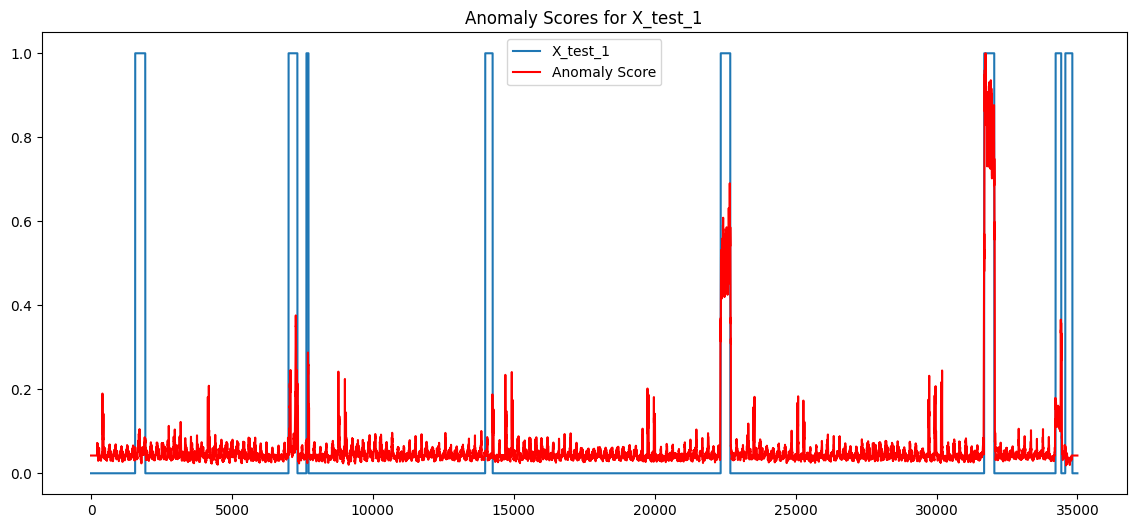

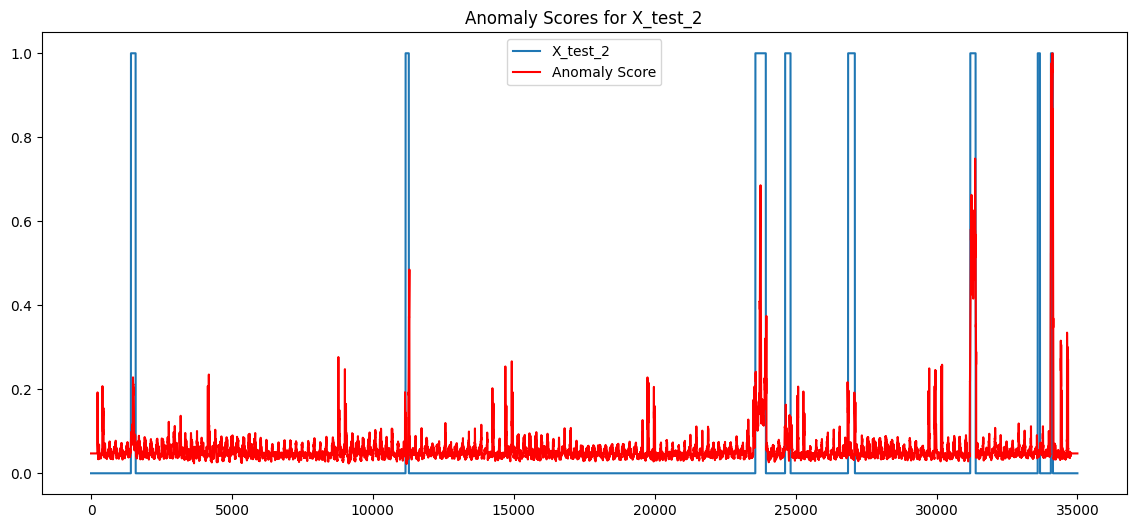

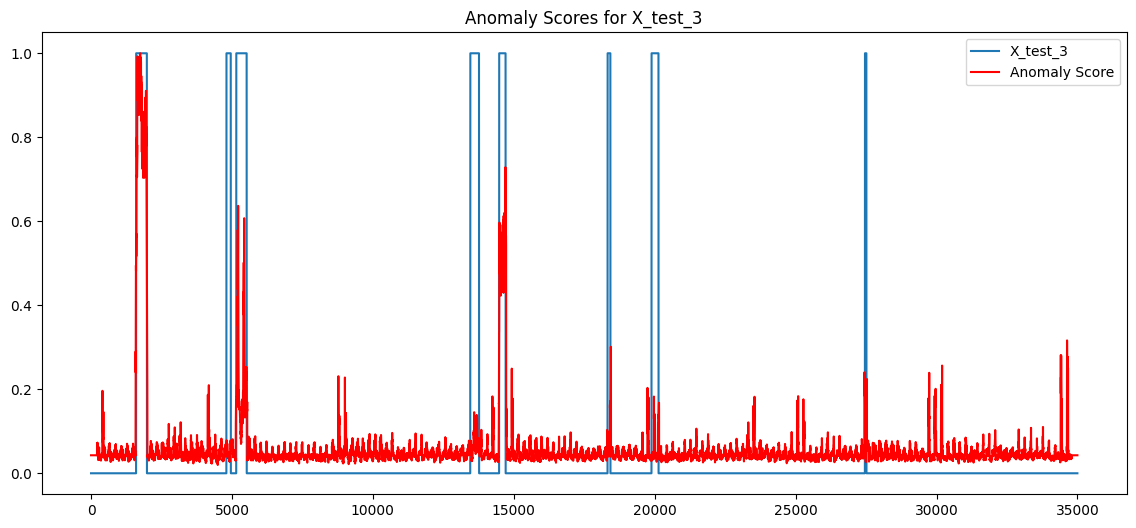

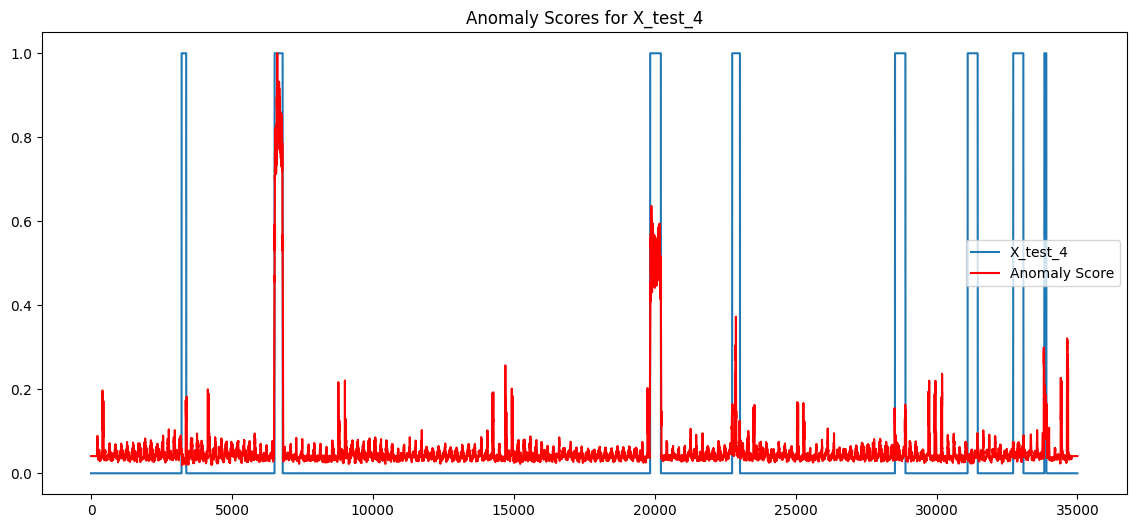

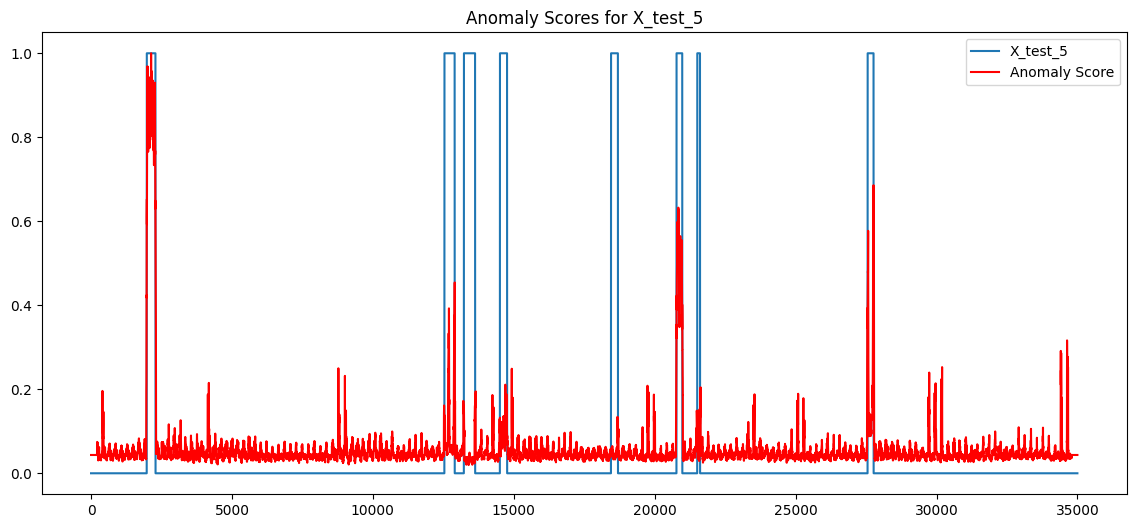

In [621]:
for i in range(1, 6):
    plt.figure(figsize=(14, 6))
    plt.plot(test_datasets[f'X_test_{i}']['labels'], label=f"X_test_{i}")
    plt.plot(predicted_scores_adjusted[f'X_test_{i}'], label="Anomaly Score", color='red')
    plt.legend()
    plt.title(f"Anomaly Scores for X_test_{i}")
    plt.show()


Visualizing on individual anomalies

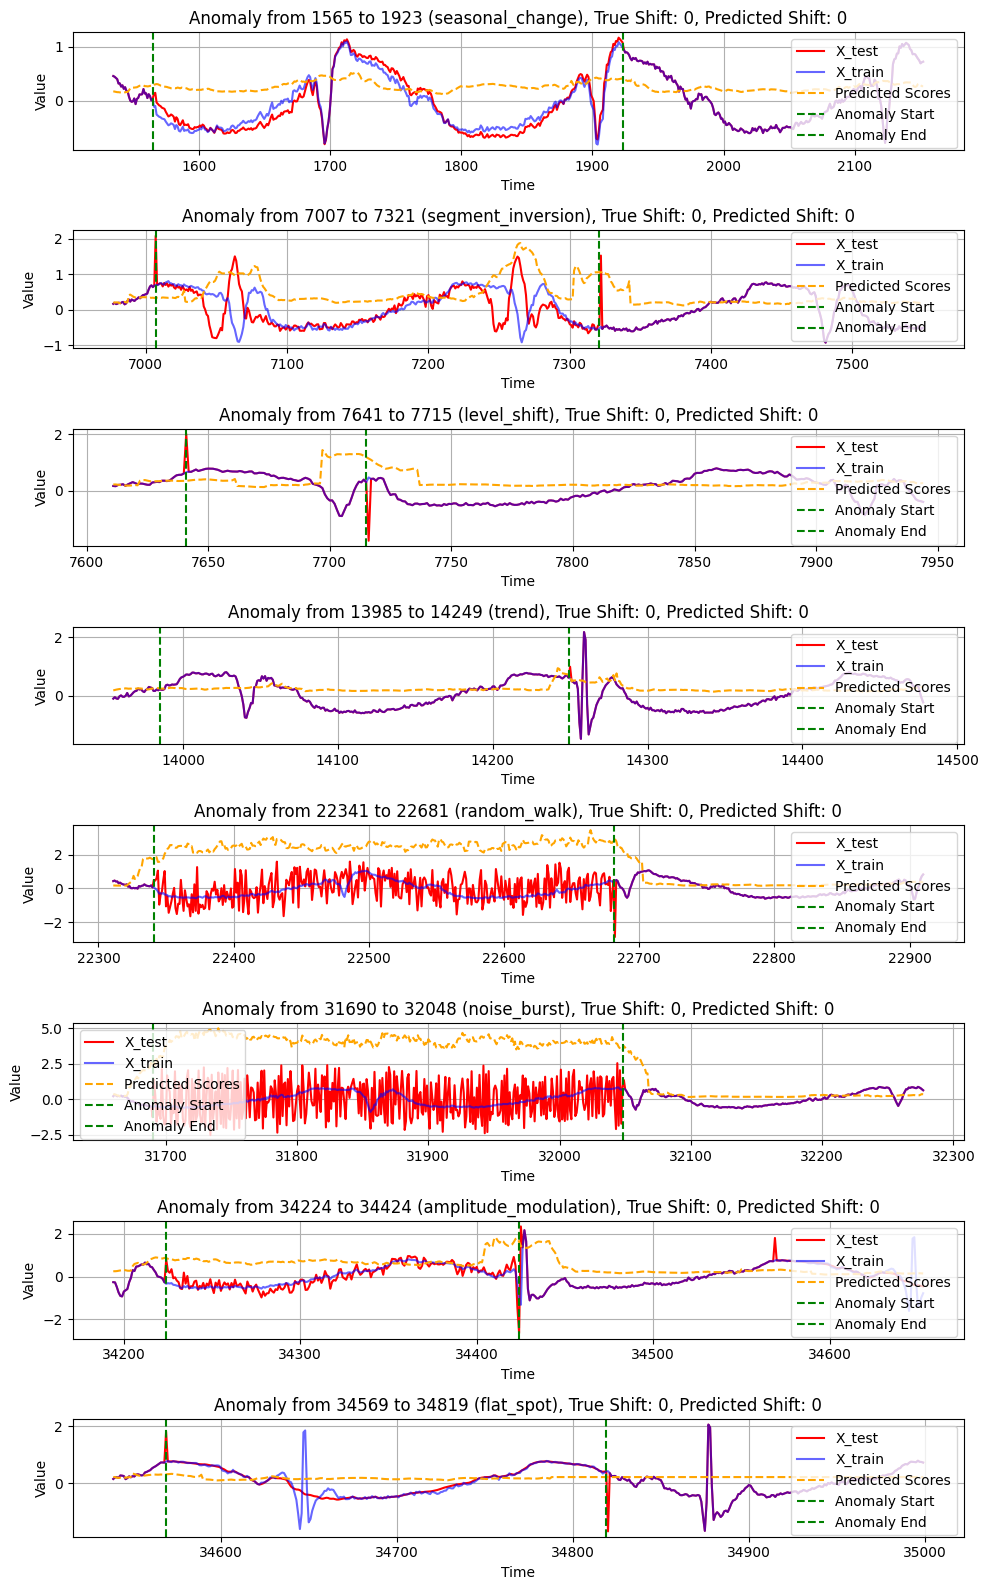

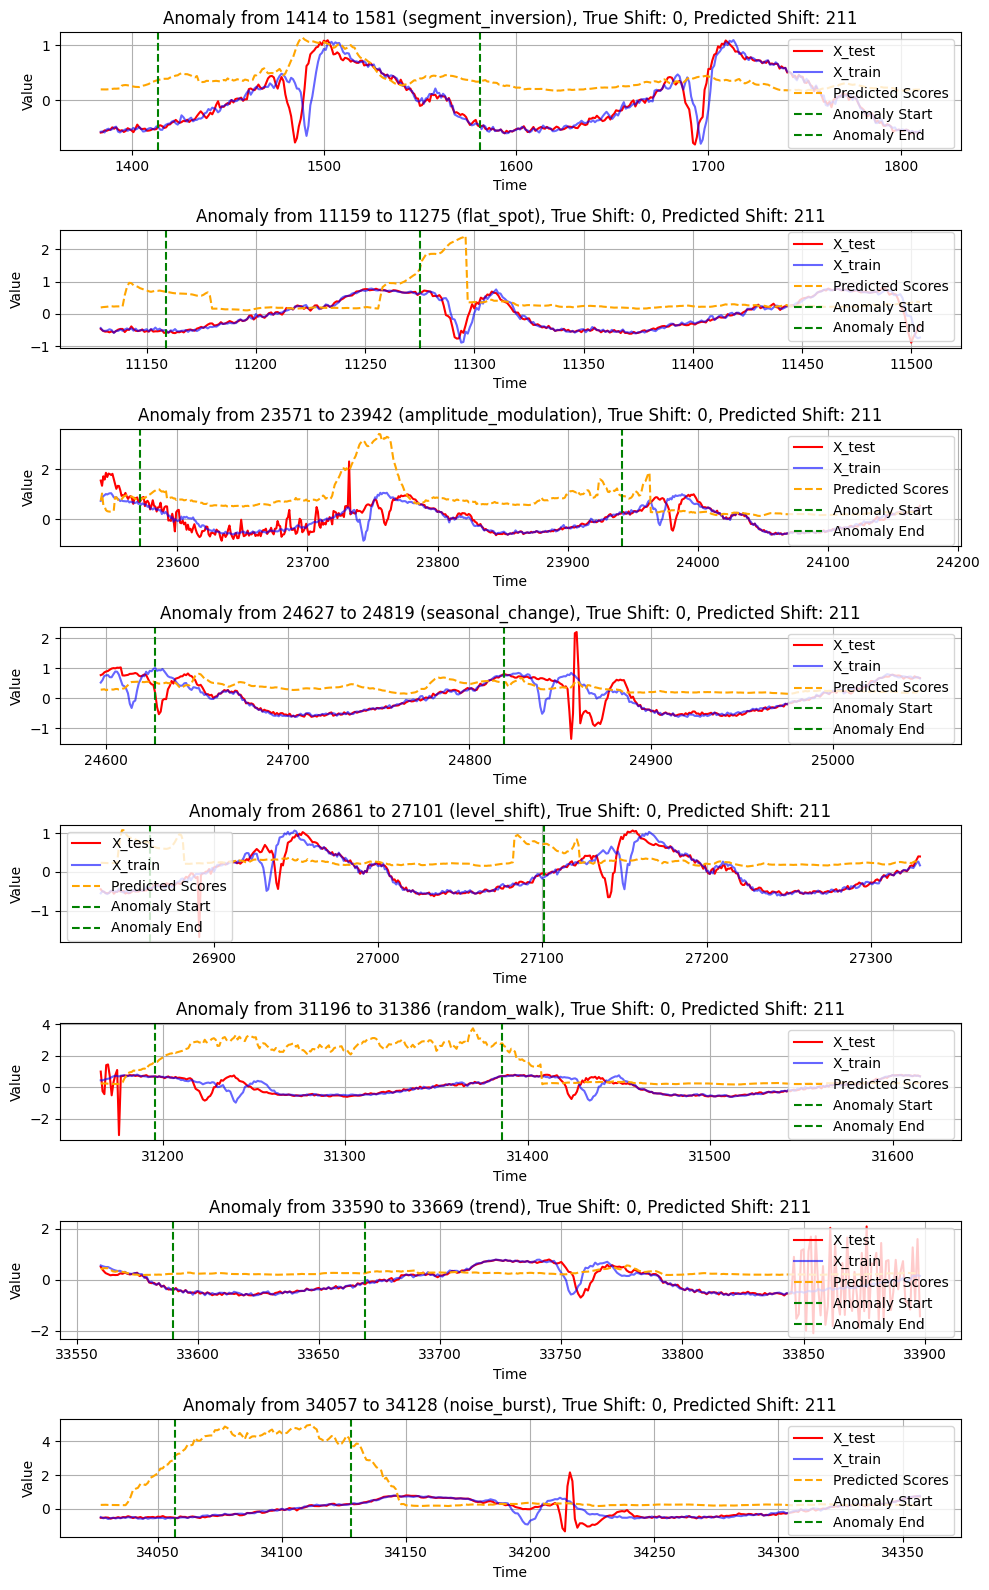

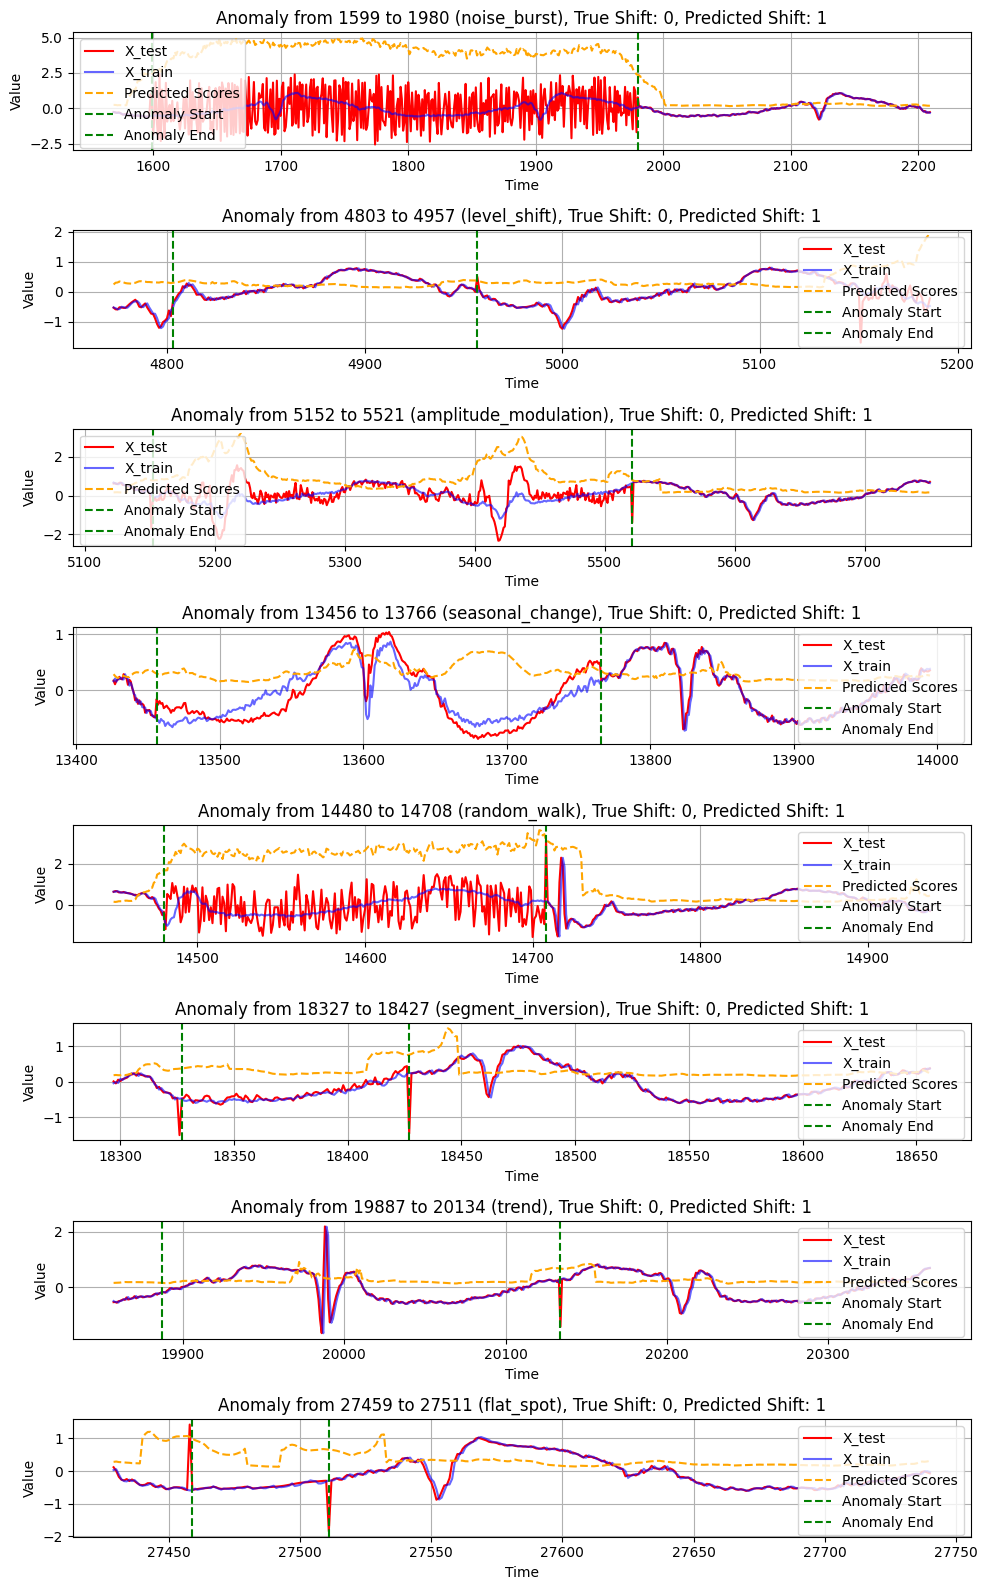

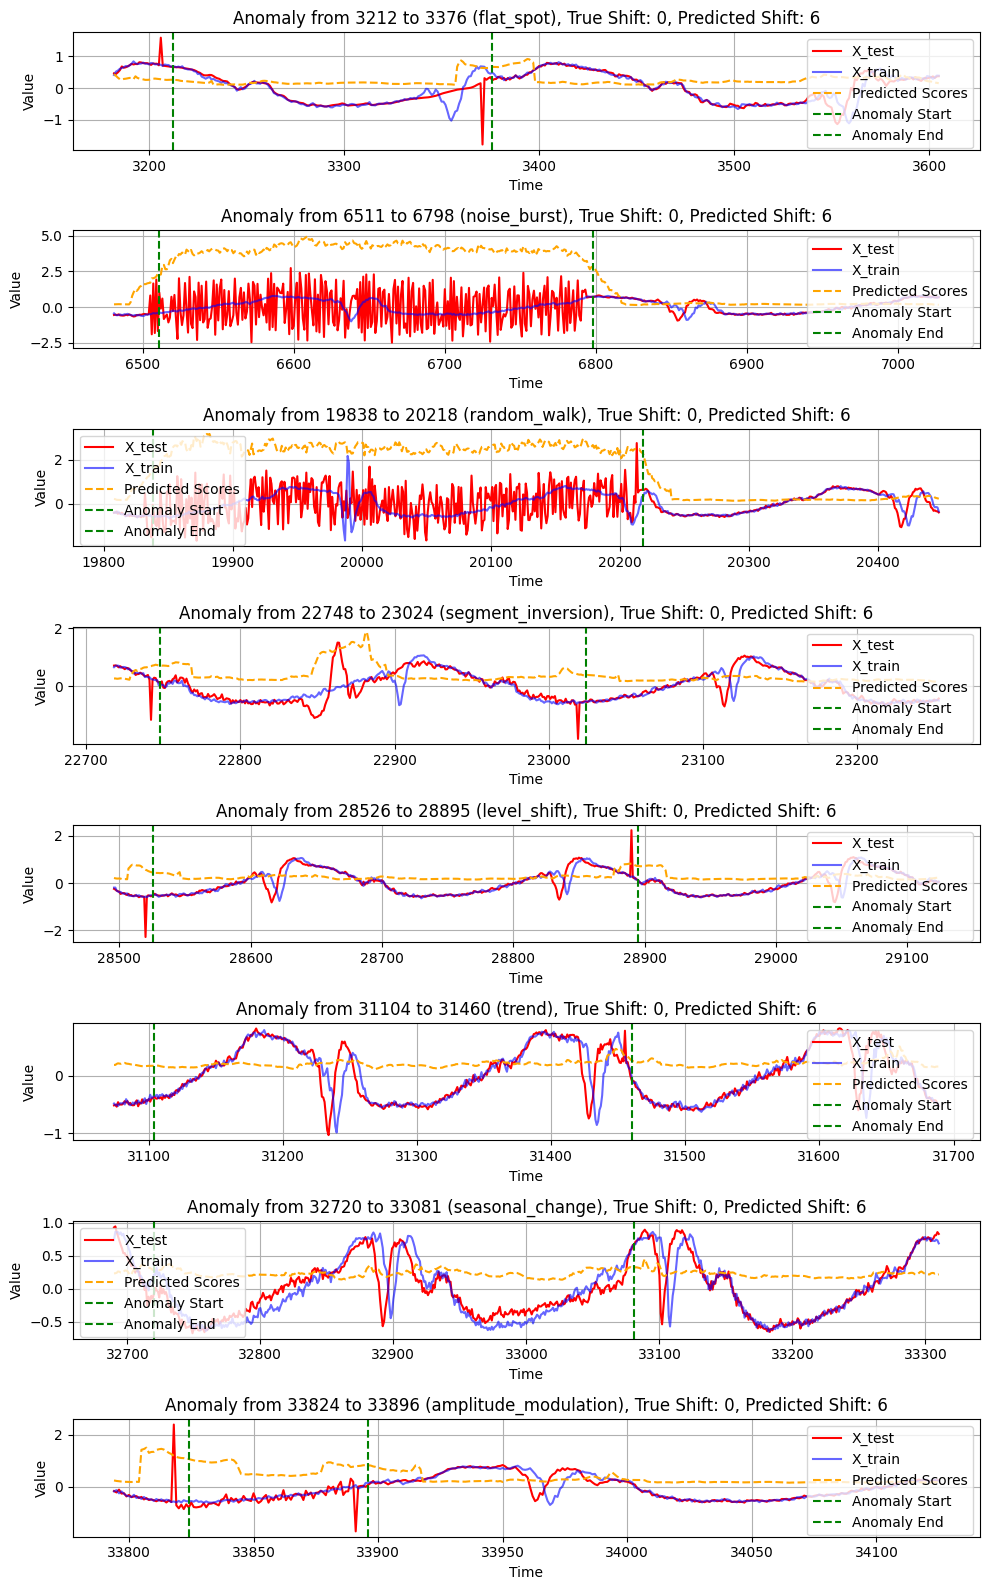

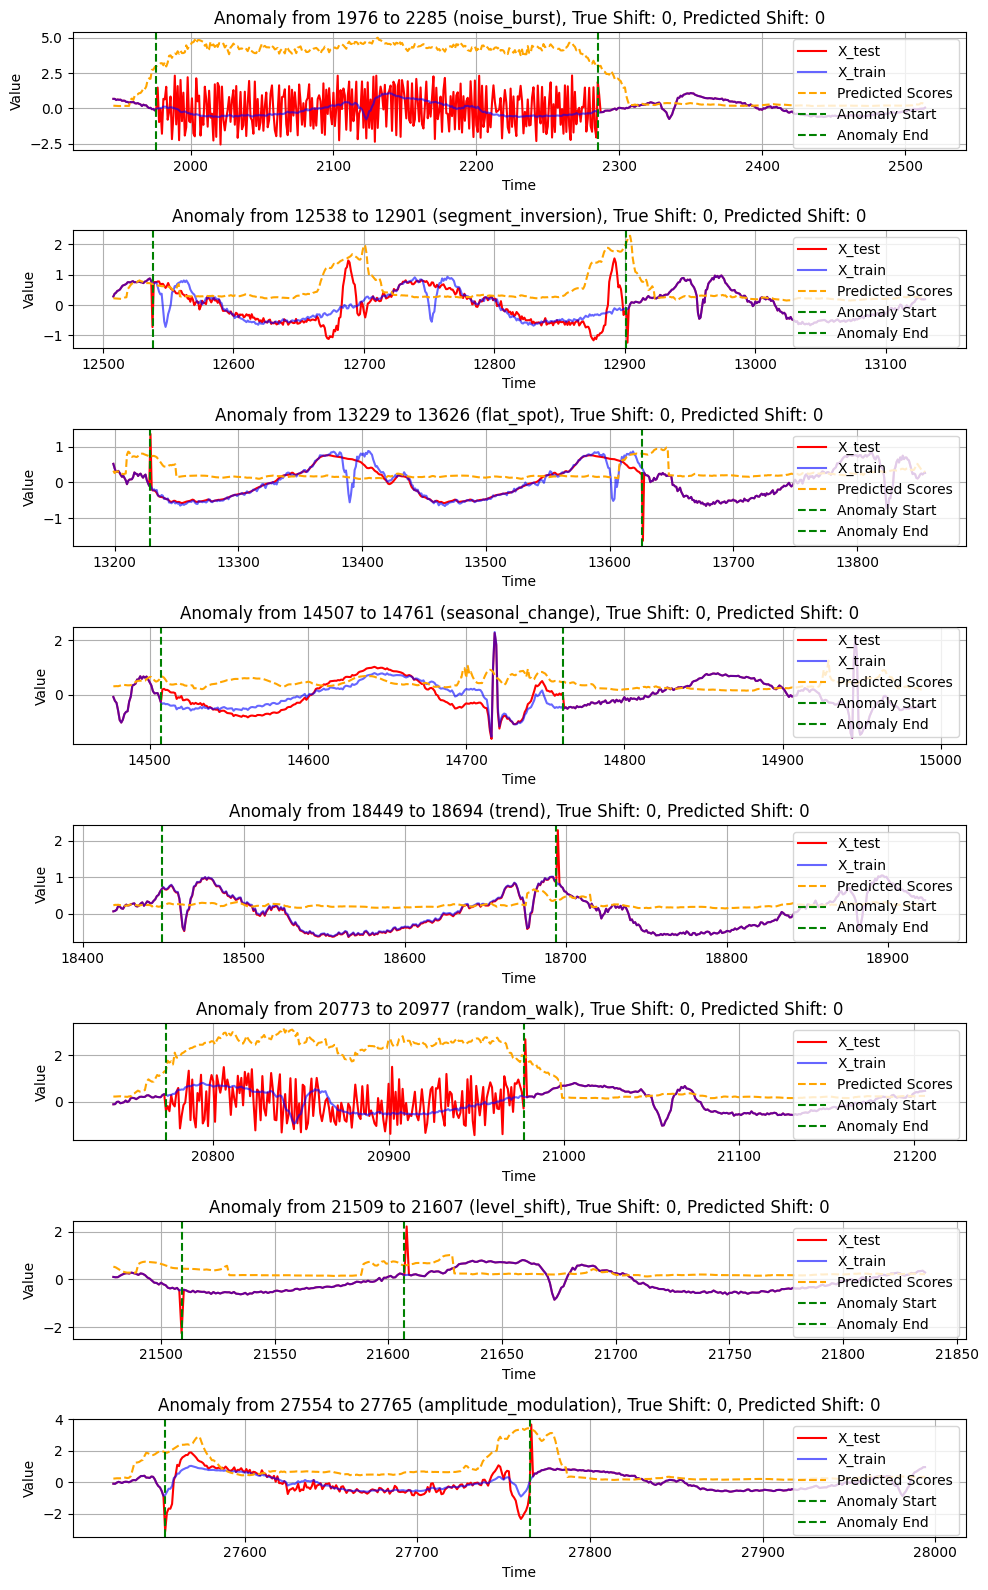

In [622]:
for i in range(1, 6):
    # Visualize anomalies
    visualize_anomalies_single(
        X_train=X_train_preprocessed,
        X_test=test_datasets_preprocessed[f'X_test_{i}']['preprocessed_data'],
        labels=test_datasets[f'X_test_{i}']['labels'],
        anomaly_types=test_datasets[f'X_test_{i}']['anomaly_types'],
        true_shift=test_datasets_preprocessed[f'X_test_{i}']['true_shift'],
        predicted_scores=predicted_scores_adjusted[f'X_test_{i}']*5,
        predicted_shift=test_datasets_preprocessed[f'X_test_{i}']['predicted_shift']
    )
